In [3]:
# Importing libraries
import numpy as np 
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

In [4]:
# Feature Engineering
# Creating Dataframes
X_train = pd.read_csv("/workspace/anomaly_lte/data/X_train.csv")

# Turning time into a datetime type
X_train['Time'] = pd.to_datetime(X_train['Time'], format = '%H:%M')


# Creating new columns for meanUE_UL_encoded and meanUE_DL_encoded (encoding will be done later)
X_train['meanUE_UL_encoded'] = X_train['meanUE_UL']
X_train['meanUE_DL_encoded'] = X_train['meanUE_DL']


# FunctionTransformer for custom One Hot Encoder for variables MeanUE_UL and MeanUE_DL
def zero_encoder(x):
    return (x == 0).astype(int)

Zero_Encoder = FunctionTransformer(zero_encoder)

# FunctionTransformer for encoding time as hours
def time_encoder(x):
    return np.array(x.iloc[:,0].dt.hour)[:, np.newaxis]

Time_Encoder = FunctionTransformer(time_encoder)

# FunctionTransformer and ColumnTransformer for log transformation 
def log_transformer(x):
    return np.log(x+10**-10) #Constant added to prevent log 0

Log_Transformer = FunctionTransformer(log_transformer)

# Pipeline for log transformation and standard scaler
Pipe = Pipeline(steps = [
    ('log', Log_Transformer),
    ('scale', StandardScaler())
])

# Fitting ColumnTranformer for set 2 (with log transformation)
preprocessor = ColumnTransformer(
    transformers=[
        ('encode cell name', OneHotEncoder(), ['CellName']),
        ('encode time', Time_Encoder, ['Time']),
        ('encode zero', Zero_Encoder, ['meanUE_UL_encoded', 'meanUE_DL_encoded']),
        ('log and scale', Pipe, ['PRBUsageUL', 'PRBUsageDL', 'meanThr_DL', 'meanThr_UL', 'maxThr_DL', 'maxThr_UL', 'meanUE_UL', 'meanUE_DL']),
        ('scale', StandardScaler(), ['maxUE_UL', 'maxUE_DL', 'maxUE_UL+DL'])
    ],
    remainder = 'passthrough'
)

preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('encode cell name', OneHotEncoder(),
                                 ['CellName']),
                                ('encode time',
                                 FunctionTransformer(func=<function time_encoder at 0x7f5f908bb420>),
                                 ['Time']),
                                ('encode zero',
                                 FunctionTransformer(func=<function zero_encoder at 0x7f5f906fdd00>),
                                 ['meanUE_UL_encoded', 'meanUE_DL_encoded']),
                                ('log and scale',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<function log_transformer at 0x7f5f906fe0c0>)),
                                                 ('scale', StandardScaler())]),
                                 ['PRBUsageUL', 'PRBUsageDL', 'meanThr_DL',
                                  'meanThr_UL', 'maxThr_DL', 'maxThr_UL',
                                  'meanUE_UL', 'meanUE_DL']),
                                ('scale', StandardScaler(),
                                 ['maxUE_UL', 'maxUE_DL', 'maxUE_UL+DL'])])

In [6]:
# Importing test data
X_df_raw = pd.read_csv("/workspace/anomaly_lte/data/X_test_100rows.csv")

# Adding Index
X_df_raw.insert(0, 'Unnamed: 0', np.arange(0, 101, 1))

# Turning time into a datetime type
X_df_raw['Time'] = pd.to_datetime(X_df_raw['Time'], format = '%H:%M')

# Creating new columns for meanUE_UL_encoded and meanUE_DL_encoded 
X_df_raw['meanUE_UL_encoded'] = X_df_raw['meanUE_UL']
X_df_raw['meanUE_DL_encoded'] = X_df_raw['meanUE_DL']

# Feature engineering
X_df = preprocessor.transform(X_df_raw)
X_df = pd.DataFrame(X_df)

# Creating new column names
Columns = ['CellName_7VLTE', 'CellName_5ALTE', 'CellName_10ALTE', 'CellName_9BLTE', 'CellName_7BLTE', 'CellName_3BLTE', 
'CellName_5BLTE', 'CellName_9ALTE', 'CellName_10CLTE', 'CellName_7ULTE', 'CellName_6ULTE', 'CellName_1BLTE', 
'CellName_2ALTE', 'CellName_7ALTE', 'CellName_8ALTE', 'CellName_6ALTE', 'CellName_3CLTE', 'CellName_6CLTE', 
'CellName_10BLTE', 'CellName_6WLTE', 'CellName_8CLTE', 'CellName_3ALTE', 'CellName_4CLTE', 'CellName_4BLTE', 
'CellName_7WLTE', 'CellName_6VLTE', 'CellName_1ALTE', 'CellName_7CLTE', 'CellName_4ALTE', 'CellName_1CLTE', 
'CellName_8BLTE', 'CellName_5CLTE', 'CellName_6BLTE', 'Time', 'meanUE_UL_encoded', 'meanUE_DL_encoded', 'PRBUsageUL', 
'PRBUsageDL', 'meanThr_DL', 'meanThr_UL', 'maxThr_DL', 'maxThr_UL', 'meanUE_DL', 'meanUE_UL', 'maxUE_DL', 'maxUE_UL', 
'maxUE_UL+DL', 'Outdated Index']

X_df.columns = Columns

# Dropping index
X_df.drop(X_df.columns[[-1]], axis = 1, inplace = True)

In [7]:
# Importing decision tree model
with open('models/train_dtree_ft2.pkl', 'rb') as model_file:
    dtree = pickle.load(model_file)

In [10]:
# Setting up SHAP explainer
explainer = shap.TreeExplainer(dtree)
shap_values = explainer.shap_values(X_df)

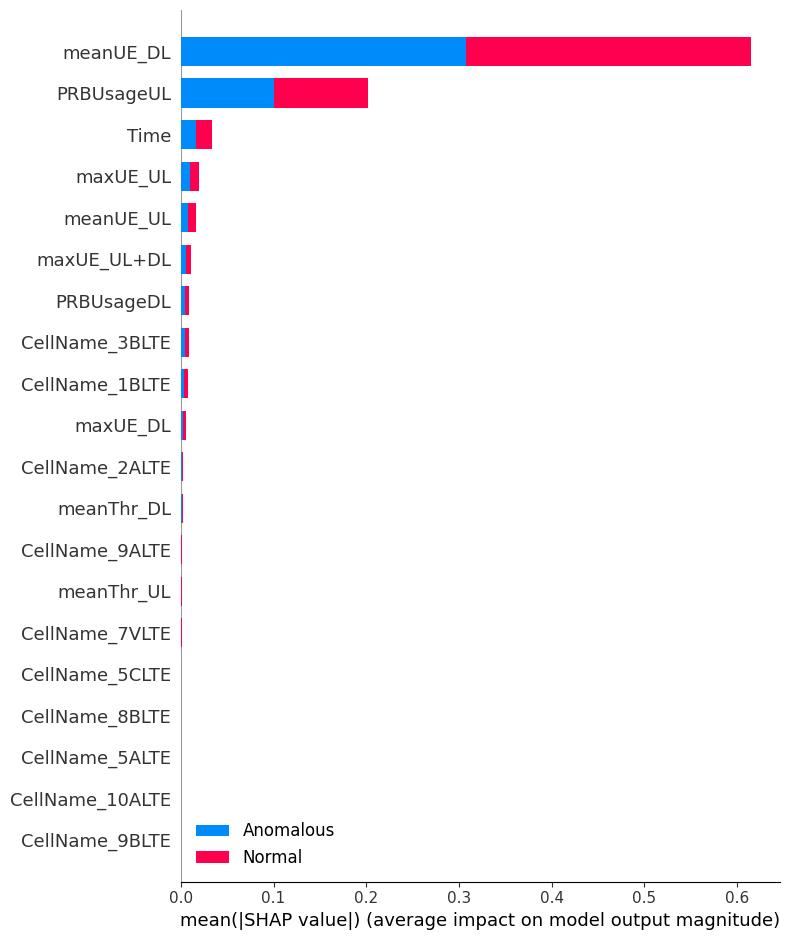

In [11]:
# Plotting Summary plot
shap.summary_plot(shap_values, X_df, plot_type='bar', class_names=['Normal', 'Anomalous'])
plt.show()